In [1]:
import json
import sys
import pandas as pd

sys.path.append('../')

from functions import *

/Users/liumukun/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [19]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.style.use('tableau-colorblind10')
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['axes.titlepad'] = 5
plt.rcParams['axes.titlesize'] = 9
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['axes.labelpad'] = 5
plt.rcParams['legend.fontsize'] = 7
plt.rcParams['font.family'] = 'serif'
plt.rcParams['axes.facecolor'] = 'white'

### Import dumps

In [3]:
with open(f"./final dumps/CMF_s_main.json", "r") as f:
    d = json.load(f)
    covariates = d["covariates"]
    median_lower = d["lower"]
    median_upper = d["upper"]
    
    covariates = [[c[0],round(c[1], 5)] for c in covariates]
    median_lower = {f"{[eval(k)[0], round(eval(k)[1],5)]}": v for k, v in median_lower.items()}
    median_upper = {f"{[eval(k)[0], round(eval(k)[1],5)]}": v for k, v in median_upper.items()}

#### Main specification

In [4]:
def loss_function1(c):
    cef = lambda cov: c[0]+c[1]*cov[0]+c[2]*cov[1]*(1-cov[0])+c[3]*cov[1]*cov[0]
    return get_loss_function(covariates, median_upper, median_lower, cef)


point1, interval1 = get_estimates(loss_function1, 4, [0,0,0,0])

print(point1)
print(interval1)

[-0.72304565  0.5287823   0.07606162  0.02765301]
[-0.7366317608398245, -0.7092798153024473, 0.45827336638139493, 0.6613706029278343, 0.0740221770579519, 0.07813811298624303, 0.020167578272969777, 0.0381033132185715]


#### Dummies specification

In [5]:
percentile = lambda p: np.percentile([c[1] for c in covariates], p)

estimates = []

for i in range(2):
    for j in range(20):
        
        if j == 19:
            covs = [c for c in covariates if c[1] >= percentile(95) and c[1] <= percentile(100) and c[0] == i]
        else:
            covs = [c for c in covariates if c[1] >= percentile(j*5) and c[1] < percentile((j+1)*5) and c[0] == i]
        
        loss_function = lambda c: get_loss_function(covs, median_upper, median_lower, lambda cov: c)
        point, interval = get_estimates(loss_function, 1, [0])
        estimates += [c[0] for c in interval]
        
print(estimates)

[-0.32007818286353046, -0.18880721115695928, -0.49294463386528353, -0.25523733451218195, -0.5074529961119335, -0.29765780110441886, -0.5458859469537944, -0.3232889998360643, -0.5434238863998709, -0.3288647499998074, -0.5355607520847017, -0.3274143621933125, -0.524358189373697, -0.3227715596793128, -0.512019870560192, -0.3161510208088722, -0.49810401630545975, -0.3089888656123103, -0.47920127483449065, -0.29842982609176555, -0.4612840797903791, -0.2888876670566768, -0.4426674397782846, -0.2766280195379127, -0.4311170033951274, -0.2538749247501689, -0.3912275870189216, -0.24920524774673652, -0.34100718965527244, -0.21663080392015538, -0.24876162992495304, -0.08907553102860616, -0.16371470123110074, -0.015176854031463873, -0.02383665403159618, 0.06395757751249452, 0.10343792307469873, 0.19346483971492323, 0.1770606969424977, 0.2784974681799162, -0.30658488115164184, 0.23036348578619262, -0.3246956045400601, 0.20959809474540358, -0.3500760482273506, 0.15333690943663478, -0.3740393682320667

### Bootstrap Confidence Intervals

In [6]:
prefixed = [filename for filename in os.listdir("./final dumps") if filename.startswith("bootstrap_s_main")]

results = []

for name in prefixed:
    with open(f"./final dumps/{name}", "r") as f:
        d = json.load(f)
        _covariates = d["covariates"]
        _median_lower = d["lower"]
        _median_upper = d["upper"]
        
        _covariates = [[c[0],round(c[1], 5)] for c in _covariates]
        _median_lower = {f"{[eval(k)[0], round(eval(k)[1],5)]}": v for k, v in _median_lower.items()}
        _median_upper = {f"{[eval(k)[0], round(eval(k)[1],5)]}": v for k, v in _median_upper.items()}
        results.append((_covariates, _median_lower, _median_upper))

#### Main specification

In [100]:
estimates1 = []

for result in results:
    
    def loss_function1(c):
        cef = lambda cov: c[0]+c[1]*cov[0]+c[2]*cov[1]*(1-cov[0])+c[3]*cov[1]*cov[0]
        return get_loss_function(result[0], result[2], result[1], cef)
    
    point1, interval1 = get_estimates(loss_function1, 4, [0,0,0,0])
    
    estimates1.append(interval1)

In [102]:
conf_intervals1 = report_intervals(estimates1, 95)

95% confidence interval for variable 0:
[-0.8566743377817307, -0.2138864943292003]
95% confidence interval for variable 1:
[0.20009213670860623, 0.7597406957219884]
95% confidence interval for variable 2:
[0.010947713060212404, 0.10734156718911854]
95% confidence interval for variable 3:
[-0.020103003490875612, 0.06441849229747894]


#### Dummies specification

In [9]:
estimates2 = []
percentile = lambda p: np.percentile([c[1] for c in covariates], p)

for result in results:

    intervals = []

    for i in range(2):
        for j in range(20):
            if j == 19:
                covs = [c for c in result[0] if c[1] >= percentile(95) and c[1] <= percentile(100) and c[0] == i]
            else:
                covs = [c for c in result[0] if c[1] >= percentile(j*5) and c[1] < percentile((j+1)*5) and c[0] == i]

            loss_function = lambda c: get_loss_function(covs, result[2], result[1], lambda cov: c)
            point, interval = get_estimates(loss_function, 1, [0])
            intervals += [c[0] for c in interval]

    estimates2.append(intervals)

In [10]:
conf_intervals2 = report_intervals(estimates2, 95)

95% confidence interval for variable 0:
[-0.5867566787213242, 0.08783548254315966]
95% confidence interval for variable 1:
[-0.5633358569407456, 0.08318274660211589]
95% confidence interval for variable 2:
[-0.5536933332683168, 0.051310717097445155]
95% confidence interval for variable 3:
[-0.5925400161178177, -0.005301976256233785]
95% confidence interval for variable 4:
[-0.5840251979169734, -0.039274387204857264]
95% confidence interval for variable 5:
[-0.5743105498312541, -0.06515459532646714]
95% confidence interval for variable 6:
[-0.5590328638708212, -0.08950341103335578]
95% confidence interval for variable 7:
[-0.537025106150872, -0.08795552359584012]
95% confidence interval for variable 8:
[-0.5085890739589766, -0.07733343968017675]
95% confidence interval for variable 9:
[-0.485147262161015, -0.07054600210661373]
95% confidence interval for variable 10:
[-0.48972233413671573, -0.06665289547707268]
95% confidence interval for variable 11:
[-0.46184697388445584, -0.043522134

### Figures

In [11]:
items = []

for i in range(20):
    item = {}
    
    item["q1"] = estimates[i*2]
    item["q3"] = estimates[i*2+1]
    item["med"] = 0
    item["whislo"] = conf_intervals2[i][0]
    item["whishi"] = conf_intervals2[i][1]
    item["label"] = f"{i*5}-{(i+1)*5}"
    item["fliers"] = []
    
    items.append(item)

In [12]:
items2 = []

for i in range(20):
    item = {}
    
    item["q1"] = estimates[(20+i)*2]
    item["q3"] = estimates[(20+i)*2+1]
    item["med"] = 0
    item["whislo"] = conf_intervals2[20+i][0]
    item["whishi"] = conf_intervals2[20+i][1]
    item["label"] = f"{i*5}-{(i+1)*5}"
    item["fliers"] = []
    
    items2.append(item)

In [101]:
func0_l = lambda r: -0.857+r*0.011
func0_u = lambda r: -0.214+r*0.107

func0_l_ = lambda r: -0.737+r*0.074
func0_u_ = lambda r: -0.709+r*0.078

func1_l = lambda r: -0.358+r*-0.002
func1_u = lambda r: 0.278+r*0.064

func1_l_ = lambda r: -0.279+r*0.02
func1_u_ = lambda r: -0.048+r*0.038

In [103]:
import matplotlib.patches as mpatches

positions = [(percentile(k*5)+percentile(k*5+5))/2 for k in range(20)]

fig, ax = plt.subplots()

bplot1 = ax.bxp(items, positions=[p-0.04 for p in positions], widths=0.08, medianprops={"linewidth":0}, patch_artist=True, capprops={"color": "red"}, whiskerprops={"color": "red"})
bplot2 = ax.bxp(items2, positions=[p+0.04 for p in positions], widths=0.08, medianprops={"linewidth":0}, patch_artist=True, capprops={"color": "blue"}, whiskerprops={"color": "blue"})

for patch in bplot1['boxes']:
    patch.set_facecolor((1,0,0,0.5))
    
for patch in bplot2['boxes']:
    patch.set_facecolor((0,0,1,0.5))
    
ax.set_xticks(range(0, 14, 2))
ax.set_xticklabels(list(range(0, 14, 2)))

ax.set_xlabel("Logged seller feedback score")
ax.set_ylabel("Normalised willingness to pay")
    
red_patch = mpatches.Patch(color='red', label="Non-police")
blue_patch = mpatches.Patch(color='blue', label="Police")

values = np.linspace(0,11.75,num=200)
# plt.plot(values, [func0_l(v) for v in values], color=(1,0,0,0.2))
# plt.plot(values, [func0_u(v) for v in values], color=(1,0,0,0.2))

plt.plot(values, [func0_l_(v) for v in values], color=(1,0,0,0.3), linestyle="--")
plt.plot(values, [func0_u_(v) for v in values], color=(1,0,0,0.3), linestyle="--")


# plt.plot(values, [func1_l(v) for v in values], color=(0,0,1,0.2))
# plt.plot(values, [func1_u(v) for v in values], color=(0,0,1,0.2))

plt.plot(values, [func1_l_(v) for v in values], color=(0,0,1,0.3), linestyle="--")
plt.plot(values, [func1_u_(v) for v in values], color=(0,0,1,0.3), linestyle="--")

plt.fill_between(values, [func0_l(v) for v in values], [func0_u(v) for v in values], facecolor="red", alpha=0.1)

plt.fill_between(values, [func1_l(v) for v in values], [func1_u(v) for v in values], facecolor="blue", alpha=0.1)

plt.legend(handles=[red_patch, blue_patch], loc="upper left")

plt.tight_layout()
fig.savefig("result.png", dpi=fig.dpi, bbox_inches="tight")


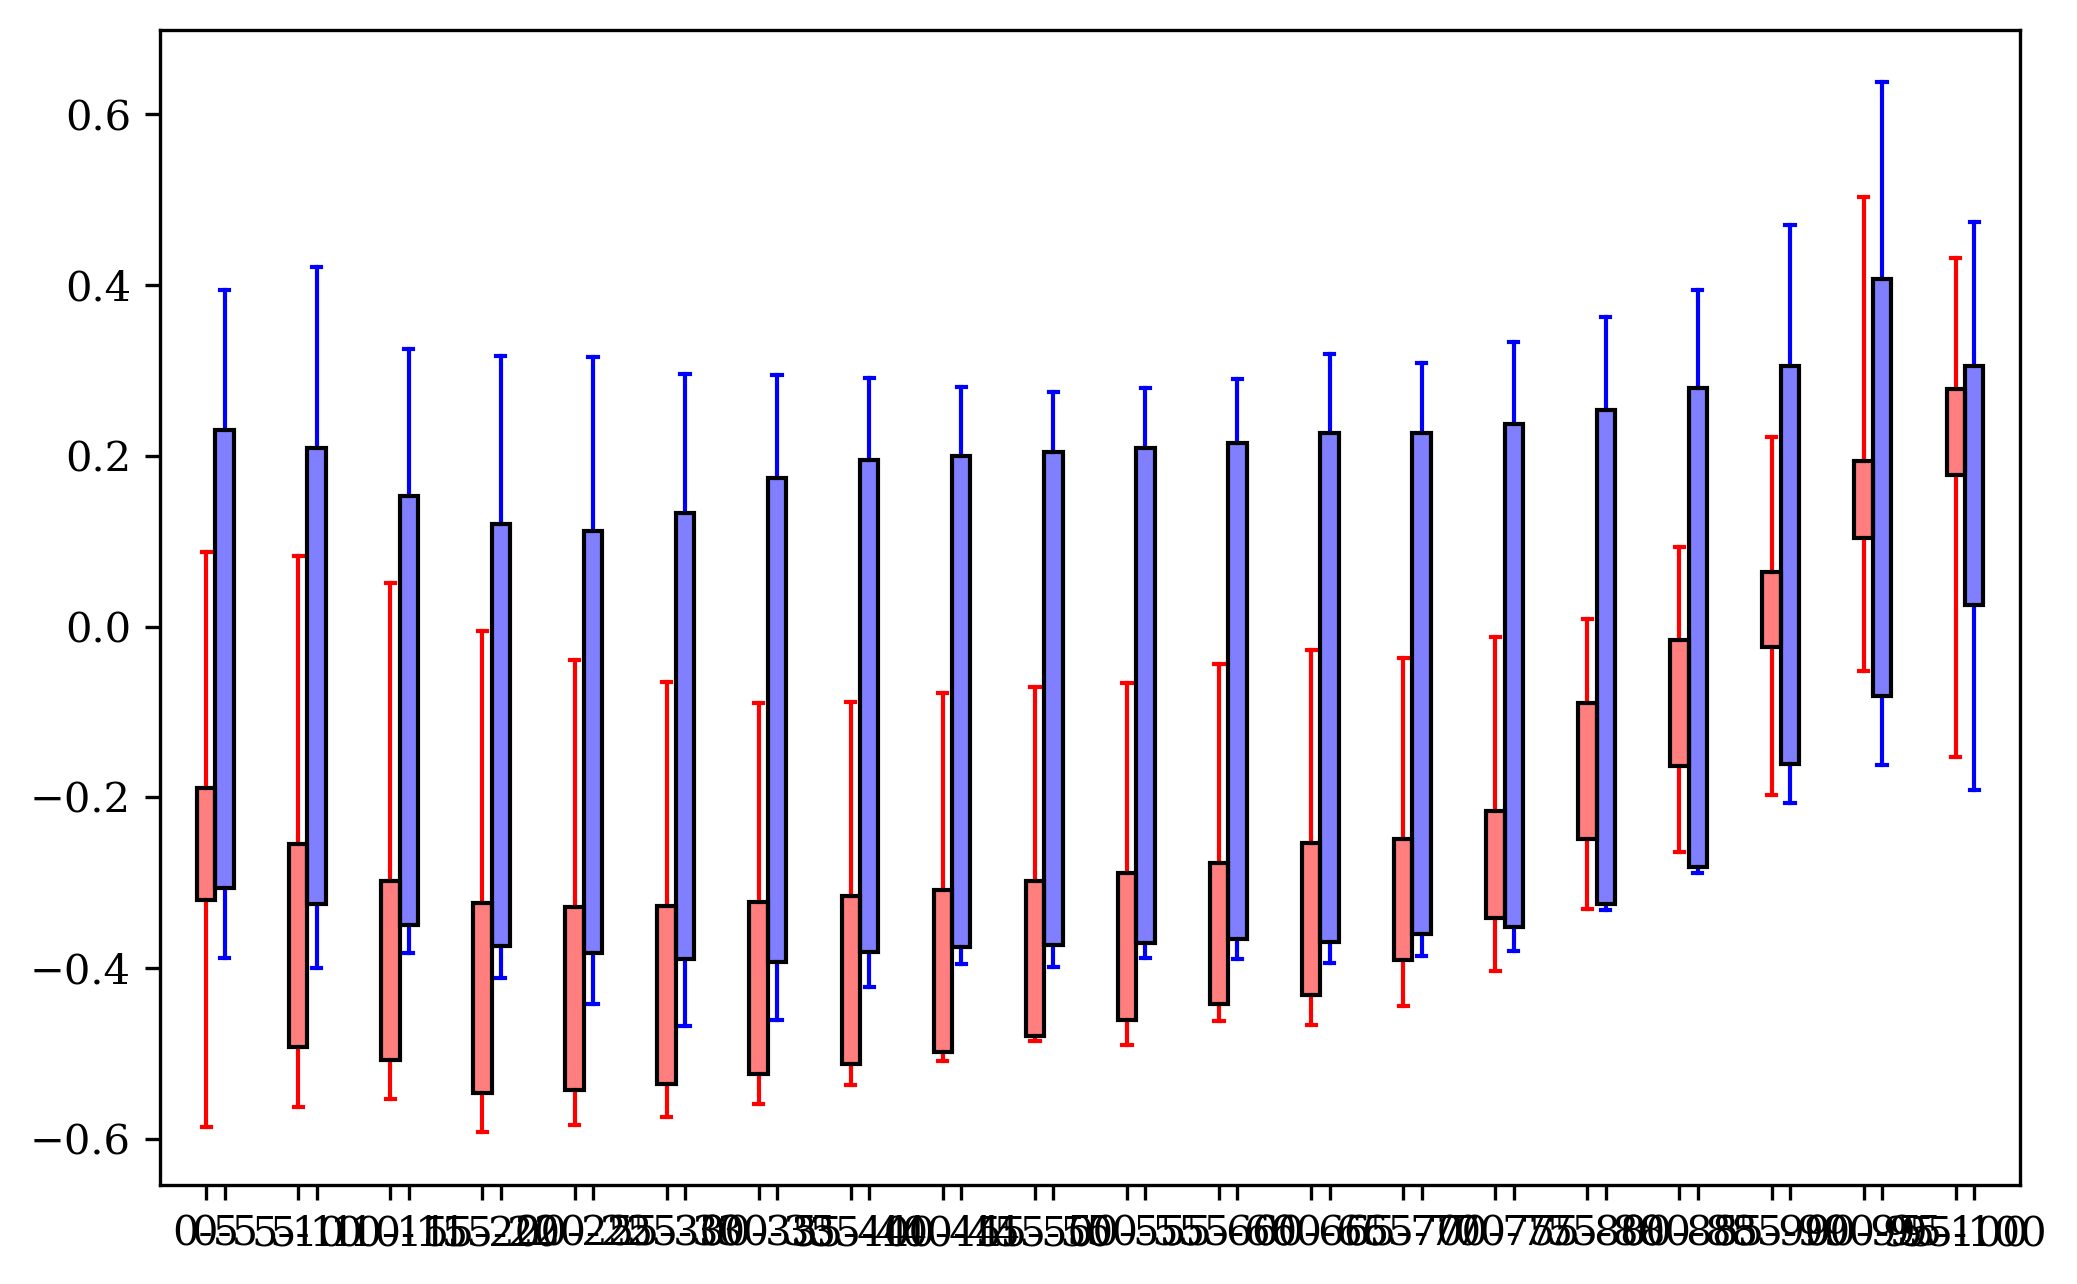

In [52]:
positions = list(range(20))

fig, ax = plt.subplots()

bplot1 = ax.bxp(items, positions=[p-0.1 for p in positions], widths=0.2, medianprops={"linewidth":0}, patch_artist=True, capprops={"color": "red"}, whiskerprops={"color": "red"})
bplot2 = ax.bxp(items2, positions=[p+0.1 for p in positions], widths=0.2, medianprops={"linewidth":0}, patch_artist=True, capprops={"color": "blue"}, whiskerprops={"color": "blue"})

for patch in bplot1['boxes']:
    patch.set_facecolor((1,0,0,0.5))
    
for patch in bplot2['boxes']:
    patch.set_facecolor((0,0,1,0.5))

plt.show()
